In [2]:
import torch
print(torch.cuda.is_available()) # should be True
# t = torch.rand(10, 10).cuda()
# print(t.device) # should be CUDA]
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
from typing import List, Tuple
from numpy import ndarray
from nilearn.image import resample_to_img
from sklearn.model_selection import StratifiedKFold
import torchio as tio
from nilearn.image import resample_to_img
from numpy import ndarray
from sklearn.model_selection import StratifiedKFold

True


In [3]:
def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

import random

def balance_dataset(subject_images, label_key='label'):
    """
    Balances the dataset by undersampling the majority class to match the size of the minority class.
    
    Parameters:
    subject_images (list): List of dictionaries containing images and labels.
    label_key (str): Key used to access the label in the dictionaries.
    
    Returns:
    list: Balanced list of dictionaries.
    """

    similar_pairs = [x for x in subject_images if x[label_key] == 1]
    dissimilar_pairs = [x for x in subject_images if x[label_key] == 0]
    num_similar_pairs = len(similar_pairs)
    num_dissimilar_pairs = len(dissimilar_pairs)

    if num_similar_pairs > num_dissimilar_pairs:
        similar_pairs = random.sample(similar_pairs, num_dissimilar_pairs)
    else:
        dissimilar_pairs = random.sample(dissimilar_pairs, num_similar_pairs)
    balanced_subject_images = similar_pairs + dissimilar_pairs
    random.shuffle(balanced_subject_images)  # Shuffle to mix the pairs
    return balanced_subject_images

def stratified_kfold_split(dataset, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    splits = list(skf.split(range(len(dataset)), dataset.labels))
    return splits

def normalize_nifti(nifti_image: nib.Nifti1Image) -> ndarray:
    return (nifti_image.get_fdata() - np.min(nifti_image.get_fdata())) / (np.max(
        nifti_image.get_fdata()) - np.min(nifti_image.get_fdata()))

def pad_slice(slice_2d: ndarray, output_size=(256, 256)) -> ndarray:
    """
    Pad a 2D slice to the desired output size with zeros.
    """
    pad_height = (output_size[0] - slice_2d.shape[0])
    pad_width = (output_size[1] - slice_2d.shape[1])
    
    padded_slice = np.pad(slice_2d, 
                          ((0, pad_height), (0, pad_width)), 
                          mode='edge')
    return padded_slice

def slice_has_high_info(slice_2d: np.ndarray, value_minimum=0.15, percentage_minimum=0.05):
    ## checks if the slice has high information by a certain value threshold and percentage of cells
    total_cells = slice_2d.size
    num_high_info_cells = np.count_nonzero(slice_2d >= value_minimum)
    percentage_high_info = num_high_info_cells / total_cells
    return percentage_high_info > percentage_minimum

def balance_classes_slices():
    return

def convert_3d_into_2d(nifti_image: ndarray, skip: int =1) -> list[Tuple[ndarray, Tuple[int, int, int]]]:
    slices = []
   
    # (axial)
    ## TODO: Use all slices for now only using every 4th slices
    for i in range(nifti_image.shape[0]):
        if i % skip == 0:
            slices.append((nifti_image[i, :, :], (i, -1 , -1)))
    #  (coronal)
    for i in range(nifti_image.shape[1]):
        if i % skip == 0:
            slices.append((nifti_image[:, i, :], (-1, i, -1)))  
    # (sagittal)
    for i in range(nifti_image.shape[2]):
        if i % skip == 0:
            slices.append((nifti_image[:, :, i], (-1, -1, i)))
    return slices

def has_tumor_cells(slice_2d: ndarray, threshold=0.15):
    ## checks if the slice has tumor cells by a certain value threshold
    return np.any(slice_2d >= threshold)




class imagePairs(Dataset):
    """
    Image dataset for each subject in the dataset
    creating only 'correct' and 'incorrect' pairs for now

    Works by passing preop or postop directory to the class
    and finds the corresponding image in the other dir and labels
    """
    def __init__(self, proc_preop: str, raw_tumor_dir: str, image_ids: list, transform=None, skip:int=1,
                 tumor_sensitivity = 0.10):
        self.root = proc_preop
        self.transform = transform
        self.data = []
        self.labels = [] # used for kfold later on
        self.image_ids = image_ids
        for root, dirs, files in os.walk(self.root):
            for filename in files:
                for image_id in self.image_ids:
                    if filename.endswith(image_id):
                        try:
                            pat_id = root.split("/")[-1]
                            print(f"Processing {pat_id}")
                            preop_nifti = nib.load(os.path.join(root, filename))
                            postop_nifti = nib.load(os.path.join(root.replace("preop", "postop"), 
                                                                filename.replace("preop", "postop")))
                            # print(preop_nifti.shape)
                            # print(postop_nifti.shape)
                            # load the tumor from the tumor directory matching the patient id
                            if "PAT" in pat_id:
                                try:
                                    tumor = nib.load(os.path.join(f"{raw_tumor_dir}/{pat_id}/anat/{pat_id}_space_T1_label-tumor.nii"))
                                    tumor_resampled = resample_to_img(tumor, preop_nifti, interpolation='nearest')
                                    tumor_norm = normalize_nifti(tumor_resampled)
                                except FileNotFoundError as e:
                                    print(f"Tumor not found for {pat_id}, {e}")
                                except Exception as e:
                                    print(f"Uncaught error, {e}")
                            
                            # resample the postop nifti to the preop nifti
                            preop_nifti_norm = normalize_nifti(preop_nifti)
                            postop_nifti_norm = normalize_nifti(postop_nifti)

                            if "-CON" in pat_id:
                                assert preop_nifti_norm.shape == postop_nifti_norm.shape
                                
                                images_pre = convert_3d_into_2d(preop_nifti_norm, skip=skip)
                                images_post = convert_3d_into_2d(postop_nifti_norm, skip = skip)

                                # Create triplets with label 1 (similar slices)
                                images_pre_pad = [(pad_slice(image[0]), image[1], 1) for image in images_pre]
                                images_post_pad = [(pad_slice(image[0]), image[1], 1) for image in images_post]
                                
                                assert len(images_pre_pad) == len(images_post_pad)
                                
                                # Create triplets (pre_slice, post_slice, label, tumor=None)
                                triplets_con = [{"pre": pre, "post": post, "label": label, "tumor": np.zeros_like(pre), 
                                                 "pat_id": pat_id, "index_pre": index_pre, "index_post": index_post} 
                                                for (pre, index_pre, label), 
                                                (post, index_post, _) in 
                                                zip(images_pre_pad, images_post_pad) if 
                                                slice_has_high_info(pre) and slice_has_high_info(post)]
                                self.data.extend(triplets_con)
                                self.labels.extend([label for (_, label, _) in images_post_pad])
                            elif "-PAT" in pat_id:
                                assert preop_nifti_norm.shape == postop_nifti_norm.shape == tumor_norm.shape

                                images_pre = convert_3d_into_2d(preop_nifti_norm, skip=skip)
                                images_post = convert_3d_into_2d(postop_nifti_norm, skip=skip)
                                mask_slices = convert_3d_into_2d(tumor_norm, skip=skip)
                                # Create triplets with label 0 if the slice contains a tumor
                                images_pre_pad = [(pad_slice(image[0]), image[1], 0 if has_tumor_cells(mask_slice[0], threshold=tumor_sensitivity) else 1) for image, mask_slice in zip(images_pre, mask_slices)]
                                images_post_pad = [(pad_slice(image[0]), image[1], 0 if has_tumor_cells(mask_slice[0], threshold=tumor_sensitivity) else 1) for image, mask_slice in zip(images_post, mask_slices)]
                                # pad the tumor mask as well
                                mask_slices_pad = [(pad_slice(mask_slice[0]), mask_slice[1]) for mask_slice in mask_slices]
                                assert len(images_pre_pad) == len(images_post_pad) == len(mask_slices_pad)
                                
                                # Create triplets (pre_slice, post_slice, label, tumor)
                                triplets_pat = [{"pre": pre, "post": post, "label": label, "tumor": mask_slice, 
                                                 "pat_id": pat_id, "index_pre": index_pre, "index_post": index_post} 
                                                for (pre, index_pre, label), (post, index_post, _), (mask_slice, _) in 
                                                zip(images_pre_pad, images_post_pad, mask_slices_pad) if 
                                                slice_has_high_info(pre) and slice_has_high_info(post)]
                                 
                                self.data.extend(triplets_pat)
                                self.labels.extend([label for (_, label, _) in images_post_pad])
                                return
                        except FileNotFoundError as e:
                            print(f"{e}, this is normal to happen for 3 subjects which have no postoperative data")
                        except Exception as e:
                            print(f"Uncaught error, {e}")
                    else:
                        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):

        if self.transform:
            pass
            # img1_file = self.transform(self.data[idx][0])
            # img2_file = self.transform(self.data[idx][1])
        return self.data[idx]
                
    


In [4]:
def create_subject_pairs(root, id):
    data = []
    for root, dirs, files in os.walk(root):
        for filename in files:
            for image_id in id:
                if filename.endswith(image_id):
                    nifti_1 = tio.ScalarImage(os.path.join(root, filename))
                    try:
                        if "preop" in root:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("preop", "postop"), filename.replace("preop", "postop")))
                        else:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("postop", "preop"), filename.replace("postop", "preop")))
                        if "-CON" in filename or "-CON" in os.path.join(root, filename):
                            # print("control for ", filename)
                            data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=1,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        elif "-PAT" in filename or "-PAT" in os.path.join(root, filename):
                                data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=0,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        else:
                            print(f"Invalid filename: {os.path.join(root, filename)}")
                    except FileNotFoundError:
                        print(f"Matching subject (pre and post) not found for {os.path.join(root, filename)}")
    return data

In [5]:

def transform_subjects(subjects: list[tio.Subject]) -> tio.SubjectsDataset:
    transforms = [
    # tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.CropOrPad((164, 164, 164)),
    ]
    transform = tio.Compose(transforms)
    return tio.SubjectsDataset(subjects, transform=transform)

def create_loaders_with_index(dataset, train_index, test_index, batch_size=1):
    train_dataset = Subset(dataset, train_index)
    test_dataset = Subset(dataset, test_index)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def create_loaders_with_split(dataset: Dataset, split=(0.8, 0.2), generator=None):
    train_t1, test_t1 = random_split(dataset=dataset, lengths=split, generator=generator)
    BATCH_SIZE=1
    train_loader_t1 = DataLoader(train_t1, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_t1 = DataLoader(test_t1, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader_t1, test_loader_t1

In [6]:
import torch.nn as nn
import torch
import numpy as np
import cv2
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

def merge_images(image1, image2, image3, output_path):
    # Create a new figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display each image on a separate subplot
    axs[0].imshow(image1, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(image2, cmap="gray")
    axs[1].axis('off')
    im = axs[2].imshow(image3)
    axs[2].axis('off')
    
    # Create a colorbar
    cbar = plt.colorbar(im, ax=axs[2], orientation='vertical')
    cbar.set_label('Similarity Distance (Scaled by 255)')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Save the merged image
    plt.savefig(output_path)
    plt.close(fig)
    
def generate_roc_curve(distances, labels, save_dir):
    # # Invert distances because lower distance indicates more similarity
    # distances = [d.cpu().item() for d in distances]
    # labels = [l.cpu().item() for l in labels]

    scores = [-d for d in distances]
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Save the plot to the specified directory
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.close()  # Close the plot to free up memory
    return thresholds
def single_layer_similar_heatmap_visual(output_t0,output_t1,dist_flag):
    print(output_t0.shape)
    interp = nn.Upsample(size=[512,512], mode='bilinear')
    c, h, w = output_t0.data.shape
    out_t0_rz = torch.transpose(output_t0.view(c, h * w), 1, 0)
    out_t1_rz = torch.transpose(output_t1.view(c, h * w), 1, 0)
    distance = various_distance(out_t0_rz,out_t1_rz,dist_flag=dist_flag)
    # print(distance)
    similar_distance_map = distance.view(h,w).data.cpu().numpy()
    similar_distance_map_rz = interp(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :]))
    # print(similar_distance_map_rz)
    similar_dis_map_colorize = cv2.applyColorMap(np.uint8(255 * similar_distance_map_rz.data.cpu().numpy()[0][0]), cv2.COLORMAP_JET)
    return similar_dis_map_colorize, out_t0_rz, out_t1_rz





In [7]:
subject_images = imagePairs(proc_preop='./../data/processed/preop/BTC-preop', 
            raw_tumor_dir='./../data/raw/preop/BTC-preop/derivatives/tumor_masks',
            image_ids=['t1_ants_aligned.nii.gz'], skip=10, tumor_sensitivity=0.15)
# balance subject_images based on label
print(f"Total number of images: {len(subject_images)}")
print("Number of similar pairs:", len([x for x in subject_images if x['label'] == 1]))
print("Number of dissimilar pairs:", len([x for x in subject_images if x['label'] == 0]))

subject_images = balance_dataset(subject_images)
print(f"Total number of images after balancing: {len(subject_images)}")
train_subject_images, val_subject_images, test_subject_images = random_split(subject_images, (0.6, 0.2, 0.2))

Processing sub-CON09
Processing sub-CON03
Processing sub-PAT25
Total number of images: 120
Number of similar pairs: 108
Number of dissimilar pairs: 12
Total number of images after balancing: 24


In [12]:
train_loader = DataLoader(train_subject_images, batch_size=16, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for index, batch in enumerate(train_loader):
    pre_batch = batch['pre'].float().to(device)
    print(pre_batch.shape)
    break
    if isinstance(batch, tuple):
        inputs, labels = batch
    else:
        inputs = batch

    print("Batch shape:", inputs.shape)


torch.Size([15, 256, 256])


sub-PAT25
0


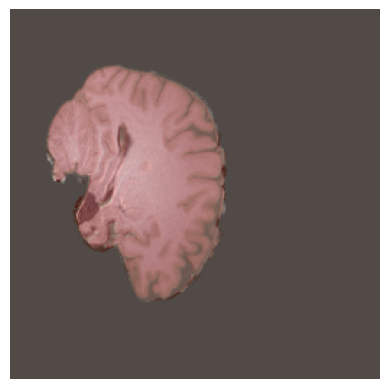

In [34]:
test = subject_images[2]
print(test['pat_id'])
print(test['label'])
# print(test['pre'])
# plt.imshow(test['pre'], cmap='gray')

# Plot the mask in red color with low opacity
# plt.imshow(test['pre'],cmap='gray')
plt.imshow(test['post'], cmap='gray')
plt.imshow(test['pre'], cmap='Reds', alpha=0.3)
plt.axis('off')
plt.show()

### DIFF

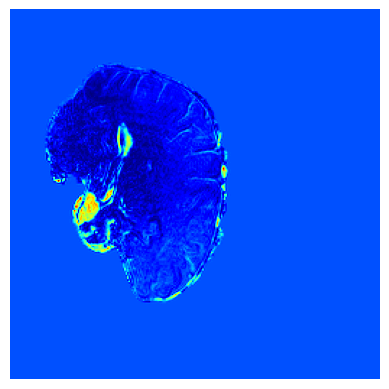

In [35]:
test['diff'] = np.abs(test['pre'] - test['post'])
plt.imshow(test['diff'], cmap='jet')
plt.axis('off')
plt.show()
# test['post'][255][255]

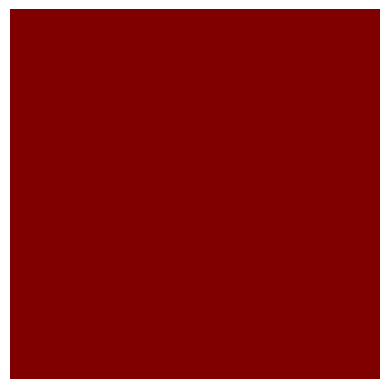

In [41]:
    # print(similar_distance_map_rz)
similar_dis_map_colorize = cv2.applyColorMap(np.uint8(test['diff']), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(similar_dis_map_colorize)


In [1]:
import pprint
torch.set_printoptions(threshold=torch.inf)

pprint.pprint(similar_dis_map_colorize)

NameError: name 'torch' is not defined

In [44]:
torch.set_printoptions(threshold=torch.inf)
np.set_printoptions(threshold=np.inf)  # Default setting
print(type(test['diff']))
print(test['diff'])
print(np.min(test['diff']))

<class 'numpy.ndarray'>
[[1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01 1.05417129e-01
  1.05417129e-01 1.05417129e-01 1.05417129e-01

In [25]:
pre = torch.from_numpy(test['pre']).float().unsqueeze(1)
post = torch.from_numpy(test['post']).float().unsqueeze(1)
heatmap, out1_trans, out2_trans = single_layer_similar_heatmap_visual(pre, post, 'l2')


torch.Size([256, 1, 256])


sub-PAT25
0


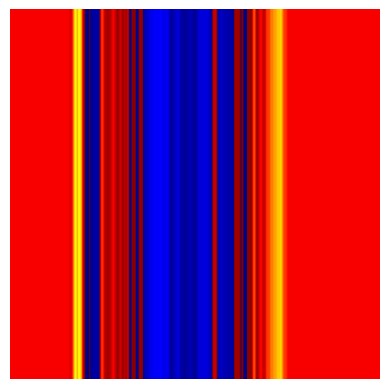

In [26]:
test = subject_images[3]
test['index_pre']
print(test['pat_id'])
print(test['label'])
# print(test['pre'])
plt.imshow(heatmap)

# Plot the mask in red color with low opacity
# plt.imshow(test['tumor'],cmap='Reds', alpha=0.6)
#plt.imshow(test['post'], cmap='Reds', alpha=0.3)
# Show the plot
plt.axis('off')
plt.show()

In [54]:
print(test['pre'].max())

0.6946996872360465
